<a href="https://colab.research.google.com/github/Gavin-Moss/Python-for-Math/blob/main/Exploration_2_Newtons_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

The effect of Newton's Method on a linear equation is trivial, so let's start our exporation with its effect on quadratics.

Real line, quadratic:

In [2]:
# A function that takes in the coefficients of a polynomial and an x value, then returns a y value
def poly_point(poly_coeffs, x):
  degree = len(poly_coeffs) - 1
  result = 0
  for i in range(degree + 1):
    result += poly_coeffs[i] * x ** (degree - i)
  return result

# A function that takes in the coefficients of a polynomial and an x value, then returns its derivative at that value
def poly_dev(poly_coeffs, x):
  new_coeffs = np.arange(len(poly_coeffs))[:0:-1] * np.array(poly_coeffs)[:-1]
  return poly_point(new_coeffs, x)

In [3]:
# A function that does Newton's Method
def poly_newton(poly_coeffs, x, precision=10):
  x0, x1 = x, x + 1
  error = 10 ** -(precision + 2)
  c = 0
  while abs(x0 - x1) > error and c != 200:
    x0, x1 = x1, x0 - poly_point(poly_coeffs, x0) / poly_dev(poly_coeffs, x0)
    c += 1
  if c == 200:
    return np.pi
  return round(x1, precision)

In [4]:
# A function that takes in n, then returns the RGB values of n "evenly spaced" colors
def evenly_spaced_colors(n):
  colors = np.zeros([n+1, 3], dtype='uint8')
  x_values = np.linspace(0, 1535, n+1, dtype='int')
  for i in range(n+1):
    if x_values[i] in range(0, 256):
      colors[i] = [255, x_values[i], 0]
    elif x_values[i] in range(256, 512):
      colors[i] = [-1-x_values[i], 255, 0]
    elif x_values[i] in range(512, 768):
      colors[i] = [0, 255, x_values[i]]
    elif x_values[i] in range(768, 1024):
      colors[i] = [0, -1-x_values[i], 255]
    elif x_values[i] in range(1024, 1280):
      colors[i] = [x_values[i], 0, 255]
    elif x_values[i] in range(1280, 1536):
      colors[i] = [255, 0, -1-x_values[i]]
  return colors[:-1]

In [68]:
poly_newton([1, 0, -2], 1.5, 250)

1.414213562373095

In [ ]:
poly_newtonCount([1, 0, -2], 1.5, 250)

In [ ]:
poly_newton([1,3,-11,12],1000)

In [9]:
def draw_1D_poly_NM(poly_coeffs, x_int, x_fin, res=500, height=100):
  x_destinations = np.zeros(res)
  x_values = np.linspace(x_int, x_fin, res)
  for i in range(res):
    x_destinations[i] = poly_newton(poly_coeffs, x_values[i], 8)
  bins = []
  for i in range(res):
    if x_destinations[i] not in bins:
      bins.append(x_destinations[i])
  if np.pi in bins:
    colors = evenly_spaced_colors(len(bins) - 1)
    bins.remove(np.pi)
  else:
    colors = evenly_spaced_colors(len(bins))
  print(bins)
  print(colors)
  colors_dict = {}
  for i in range(len(bins)):
    colors_dict[bins[i]] = colors[i]
  print(colors_dict)
  img_arr = np.zeros([height, res, 3], dtype='uint8')
  for i in range(res):
    if x_destinations[i] != np.pi:
      img_arr[:, i] = colors_dict[x_destinations[i]]
  img = Image.fromarray(img_arr)
  display(img)

In [ ]:
draw_1D_poly_NM([-0.3, -0.9, 0.9, 2.5, -2.1, -1.2, 0.5], -3, 2, res=2000, height=300)

NOTES FOR ME:


*  going to try to visualize the rate of converge of newtons method using matplotlib
*  newton's method is an algorithm which estimates the root of polynomials

In [27]:
# A function that counts how many times it iterates
def poly_newtonCount(poly_coeffs, x, precision=10):
  x0, x1 = x, x + 1
  error = 10 ** -(precision + 2)
  c = 0
  while abs(x0 - x1) > error and c != 200:
    x0, x1 = x1, x0 - poly_point(poly_coeffs, x0) / poly_dev(poly_coeffs, x0)
    c += 1
  if c == 200:
    return np.pi
  return c

In [71]:
def GraphRateOfConvergence(poly_coeffs, x):
  #poly_newton(poly_coeffs,x) #this function takes the coefficient of a polynomial, and performs newtons method to estimate it's roots
  #lets make a line plot to show rate of convergence?

  root = poly_newton([1, 0, -2], 1.5, 100) #this is the root with precision to 100 digits
  #error = abs((SOMETHING) - root) this something should be xn+1 everytime we iterate newtons method, but im not sure how to get that

  iterations = np.arange(1,poly_newtonCount(poly_coeffs,x,1000)+1) #counts the iterations
#NOTE, either i'm misunderstanding the count or our code is very efficient, cuz it seems like it always iterates 10 times 
#in this example
  test = np.linspace(1,poly_newton(poly_coeffs,x),10) #???

  plt.figure()
  plt.plot(iterations, test, alpha = 0.5, c = 'blue')
  plt.xlabel('Iterations')
  plt.ylabel('Error') #as of right now, the y axis is definitely not the error.

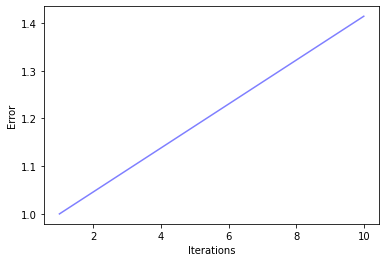

In [72]:
GraphRateOfConvergence([1, 0, -2], 1.5)

In [ ]:
poly_newtonCount([1,0,-2],1.5)